## Data Preprocessing Analysis 

This notebook experiments with various transformation techniques to determine the optimal preprocessing strategy for the dataset. It does not implement the final training pipelines; instead, the findings here dictate the architecture defined in the project's executable scripts (preprocessing.py).


### Import Packages 

In [55]:
# For data manipulation
import numpy as np
import pandas as pd
from pathlib import Path

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    PowerTransformer,
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# For saving pipeline templates
import joblib

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

### Load Dataset 

In [57]:
# Move one level up (to the project root), then into data/raw
data_dir = Path().resolve().parent / "data" / "raw"

# Load dataset
df = pd.read_csv(data_dir / "train.csv")

print(f" Dataset loaded successfully from: {data_dir}")
df.head()


 Dataset loaded successfully from: C:\Users\hp\Documents\DA projects\Beats_per_second\data\raw


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [6]:
## inspect shape 
df.shape

(524164, 11)

In [8]:
# Drop the 'id' column since it carries no predictive information
df = df.drop(columns=['id'])


In [10]:
# Separate features and target
X = df.drop(columns=["BeatsPerMinute"])
y = df["BeatsPerMinute"]

print(f"\nFeatures: {X.shape[1]}")
print(f"Target: {y.name}")


Features: 9
Target: BeatsPerMinute


In [12]:
# Define feature groups based on EDA skewness analysis
feature_groups = {
    'highly_skewed': [
        'InstrumentalScore',      # Skewness: 1.04
        'VocalContent',           # Skewness: 0.79
        'AcousticQuality'         # Skewness: 0.79
    ],
    
    'moderately_skewed': [
        'LivePerformanceLikelihood'  # Skewness: 0.39
    ],
    
    'approximately_normal': [
        'RhythmScore',            # Skewness: 0.17
        'AudioLoudness',          # Skewness: -0.31
        'MoodScore',              # Skewness: -0.27
        'TrackDurationMs',        # Skewness: -0.19
        'Energy'                  # Skewness: -0.03
    ]
}

# Display feature grouping
print("Feature Grouping by Distribution Characteristics:\n")
for group_name, features in feature_groups.items():
    print(f"{group_name.upper().replace('_', ' ')}:")
    for feature in features:
        print(f"  • {feature}")
    print()

Feature Grouping by Distribution Characteristics:

HIGHLY SKEWED:
  • InstrumentalScore
  • VocalContent
  • AcousticQuality

MODERATELY SKEWED:
  • LivePerformanceLikelihood

APPROXIMATELY NORMAL:
  • RhythmScore
  • AudioLoudness
  • MoodScore
  • TrackDurationMs
  • Energy



Rationale:

Highly skewed features require transformation to approximate normality for linear models
Moderately skewed features may benefit from transformation but can be tested both ways
Approximately normal features can be used as-is with only scaling applied

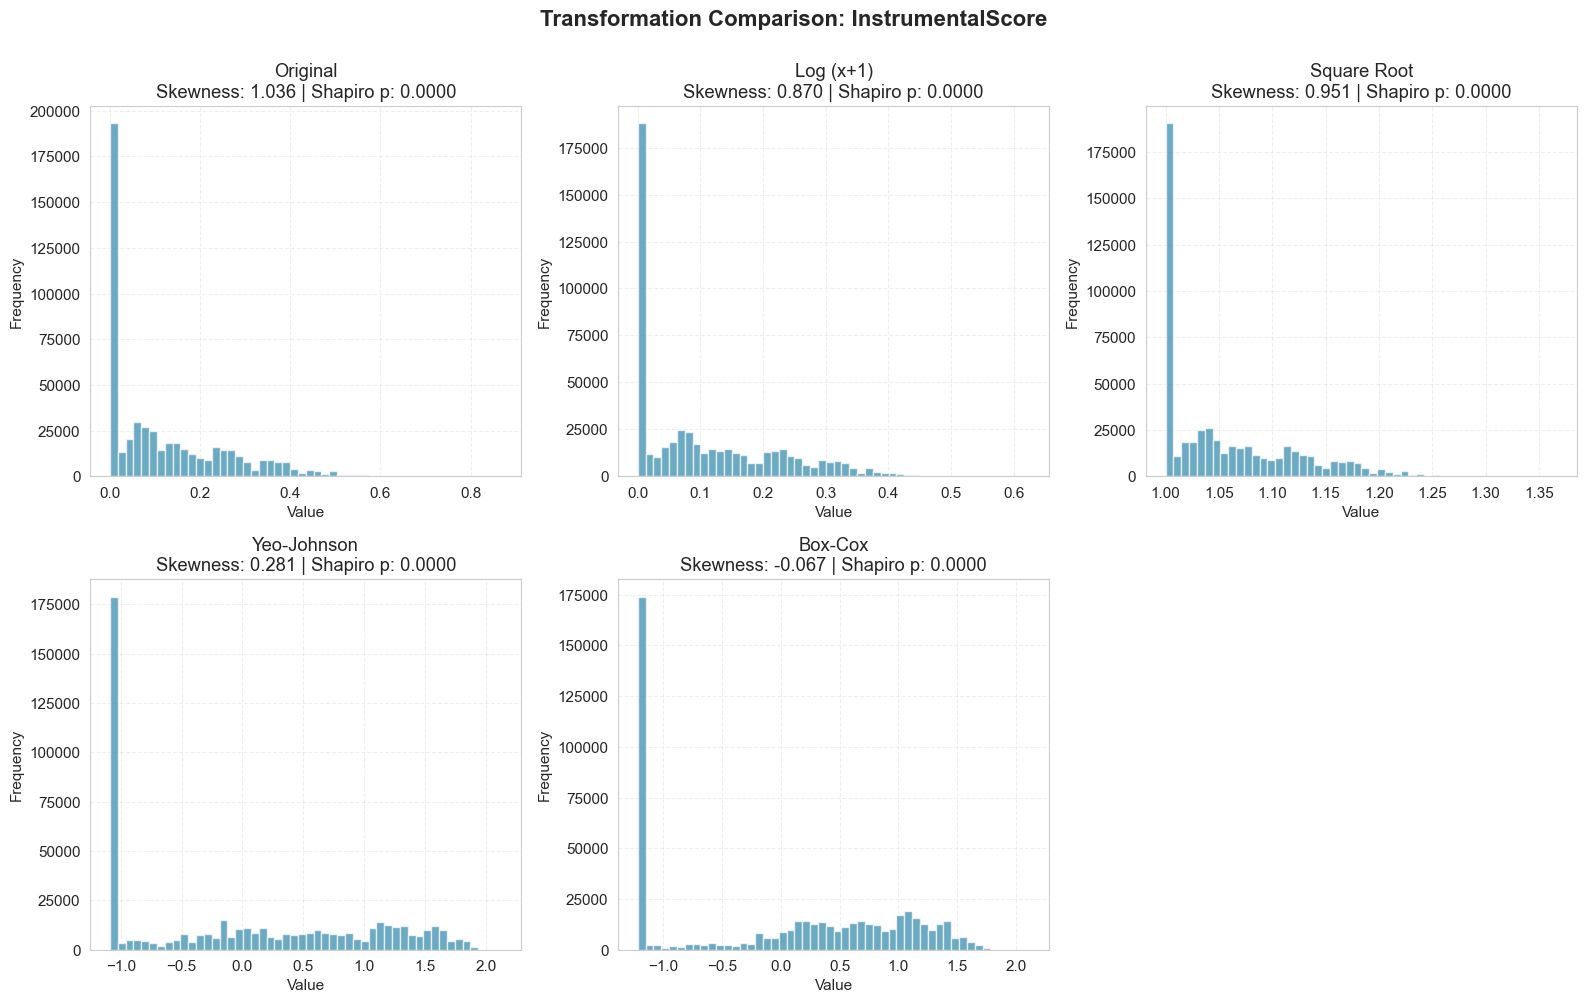


InstrumentalScore - Transformation Results (Ranked by Absolute Skewness):



,Transformation,Skewness,Abs_Skewness,Shapiro_p
4,Box-Cox,-0.067072,0.067072,1.115970e-55
3,Yeo-Johnson,0.280882,0.280882,6.351417e-55
1,Log (x+1),0.869731,0.869731,2.538243e-56
2,Square Root,0.950510,0.950510,5.231139e-57
0,Original,1.036282,1.036282,8.552891e-58


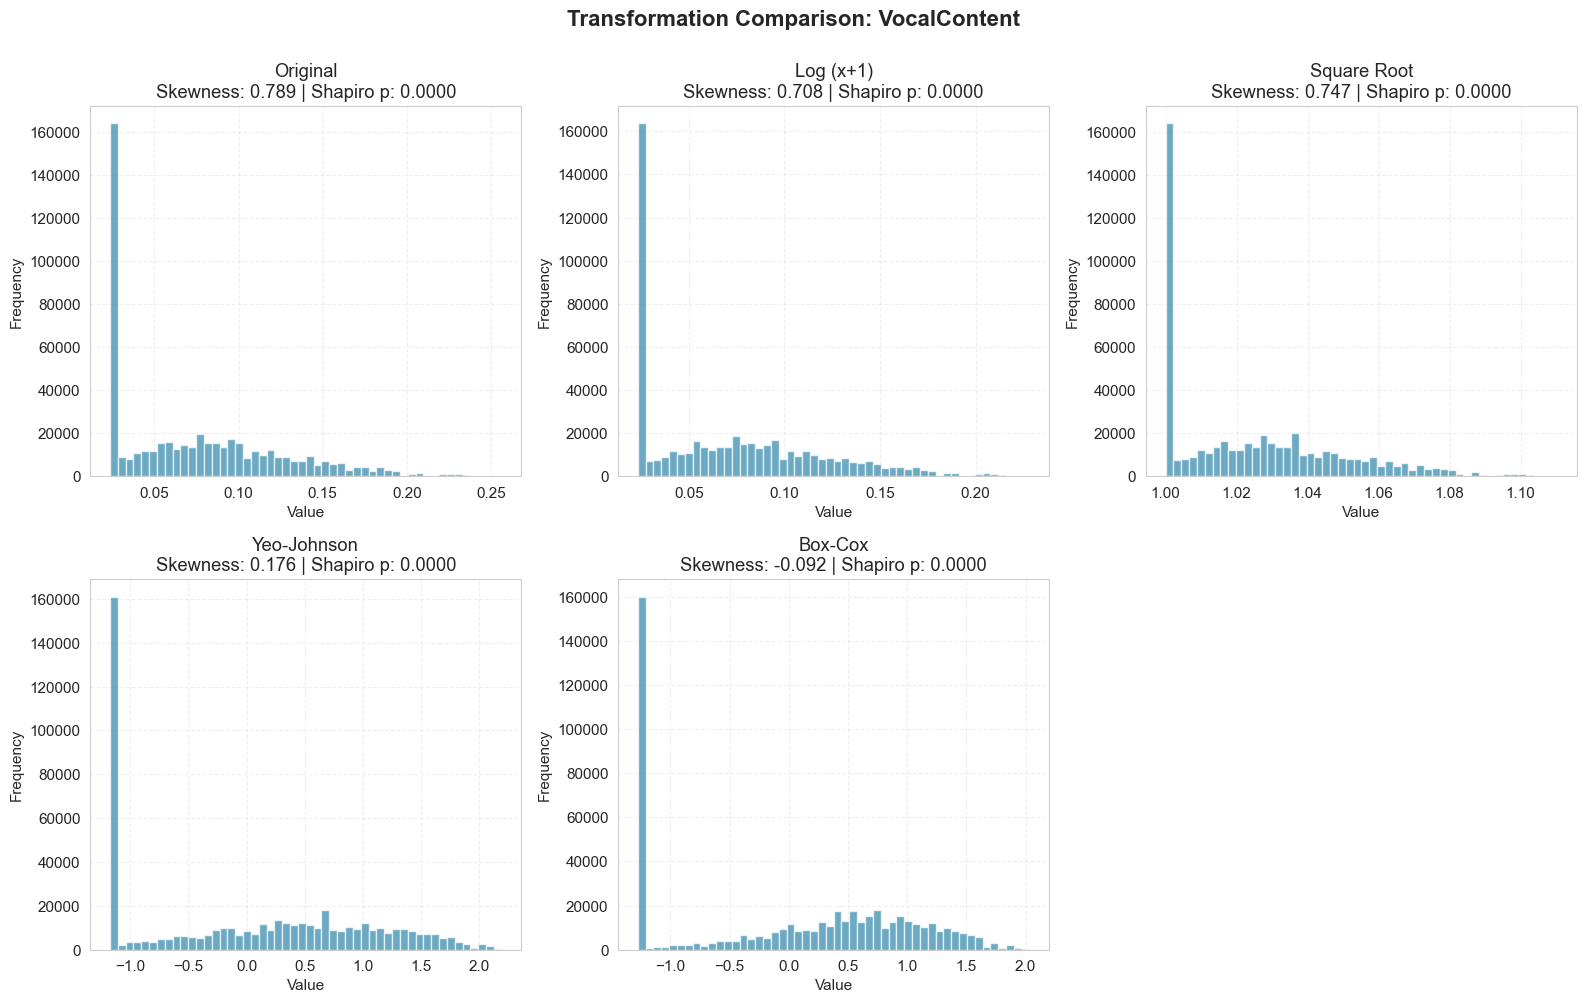


VocalContent - Transformation Results (Ranked by Absolute Skewness):



,Transformation,Skewness,Abs_Skewness,Shapiro_p
4,Box-Cox,-0.092435,0.092435,4.921329e-52
3,Yeo-Johnson,0.175811,0.175811,1.942440e-50
1,Log (x+1),0.708346,0.708346,7.106937e-51
2,Square Root,0.747243,0.747243,3.462027e-51
0,Original,0.789109,0.789109,1.507702e-51


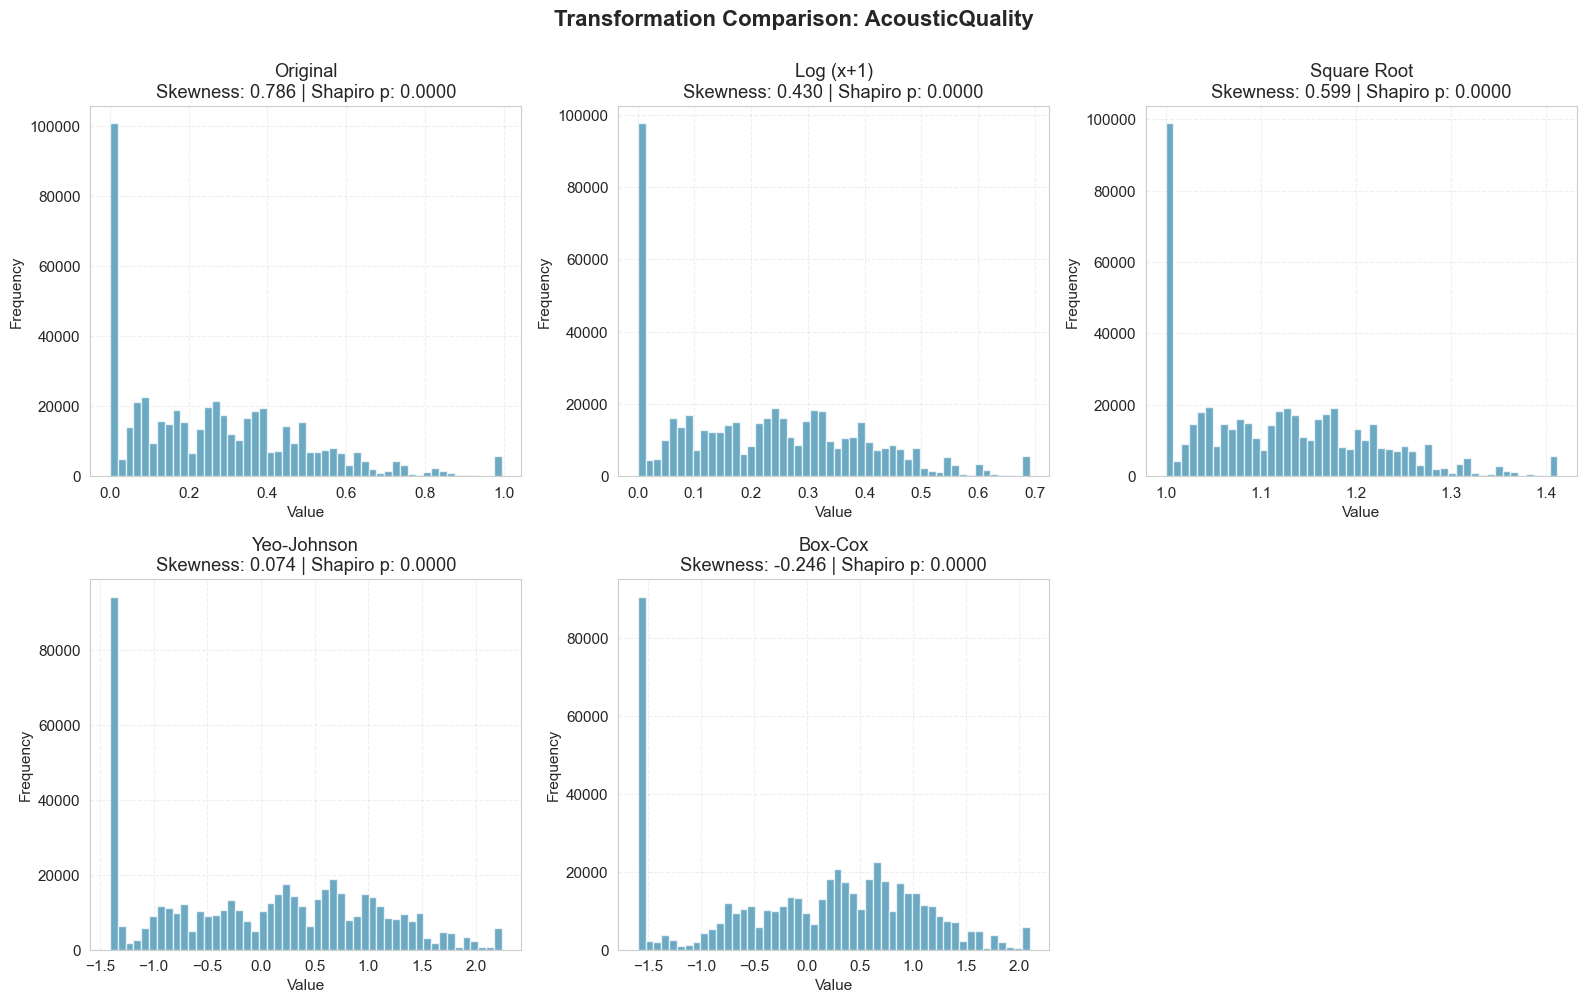


AcousticQuality - Transformation Results (Ranked by Absolute Skewness):



,Transformation,Skewness,Abs_Skewness,Shapiro_p
3,Yeo-Johnson,0.074225,0.074225,1.216924e-39
4,Box-Cox,-0.246069,0.246069,3.232519e-40
1,Log (x+1),0.430255,0.430255,2.527547e-40
2,Square Root,0.598624,0.598624,2.990823e-42
0,Original,0.785963,0.785963,6.159311e-45


In [14]:
from scipy.stats import skew, shapiro
from sklearn.preprocessing import PowerTransformer

def compare_transformations(data, feature_name):
    """
    Compare original vs. transformed distributions for a single feature.
    Tests: Log, Square Root, Yeo-Johnson, Box-Cox
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'Transformation Comparison: {feature_name}', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Get feature data
    original = data[feature_name].values.reshape(-1, 1)
    
    transformations = {
        'Original': original,
        'Log (x+1)': np.log1p(original),
        'Square Root': np.sqrt(original - original.min() + 1),
        'Yeo-Johnson': PowerTransformer(method='yeo-johnson').fit_transform(original),
        'Box-Cox': PowerTransformer(method='box-cox').fit_transform(original - original.min() + 0.01)
    }
    
    results = []
    
    for idx, (name, transformed) in enumerate(transformations.items()):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Calculate statistics
        skewness = skew(transformed.flatten())
        _, p_value = shapiro(transformed.flatten()[:5000])  # Sample for speed
        
        # Plot
        ax.hist(transformed, bins=50, color='#2E86AB', alpha=0.7, edgecolor='white')
        ax.set_title(f'{name}\nSkewness: {skewness:.3f} | Shapiro p: {p_value:.4f}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(alpha=0.3, linestyle='--')
        
        results.append({
            'Transformation': name,
            'Skewness': skewness,
            'Abs_Skewness': abs(skewness),
            'Shapiro_p': p_value
        })
    
    # Remove empty subplot
    fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Display results table
    results_df = pd.DataFrame(results).sort_values('Abs_Skewness')
    print(f"\n{feature_name} - Transformation Results (Ranked by Absolute Skewness):\n")
    display(results_df)
    print(f"\n{'='*70}\n")
    
    return results_df

# Test transformations on highly skewed features
transformation_results = {}
for feature in feature_groups['highly_skewed']:
    transformation_results[feature] = compare_transformations(df, feature)

MODERATELY SKEWED FEATURE ANALYSIS


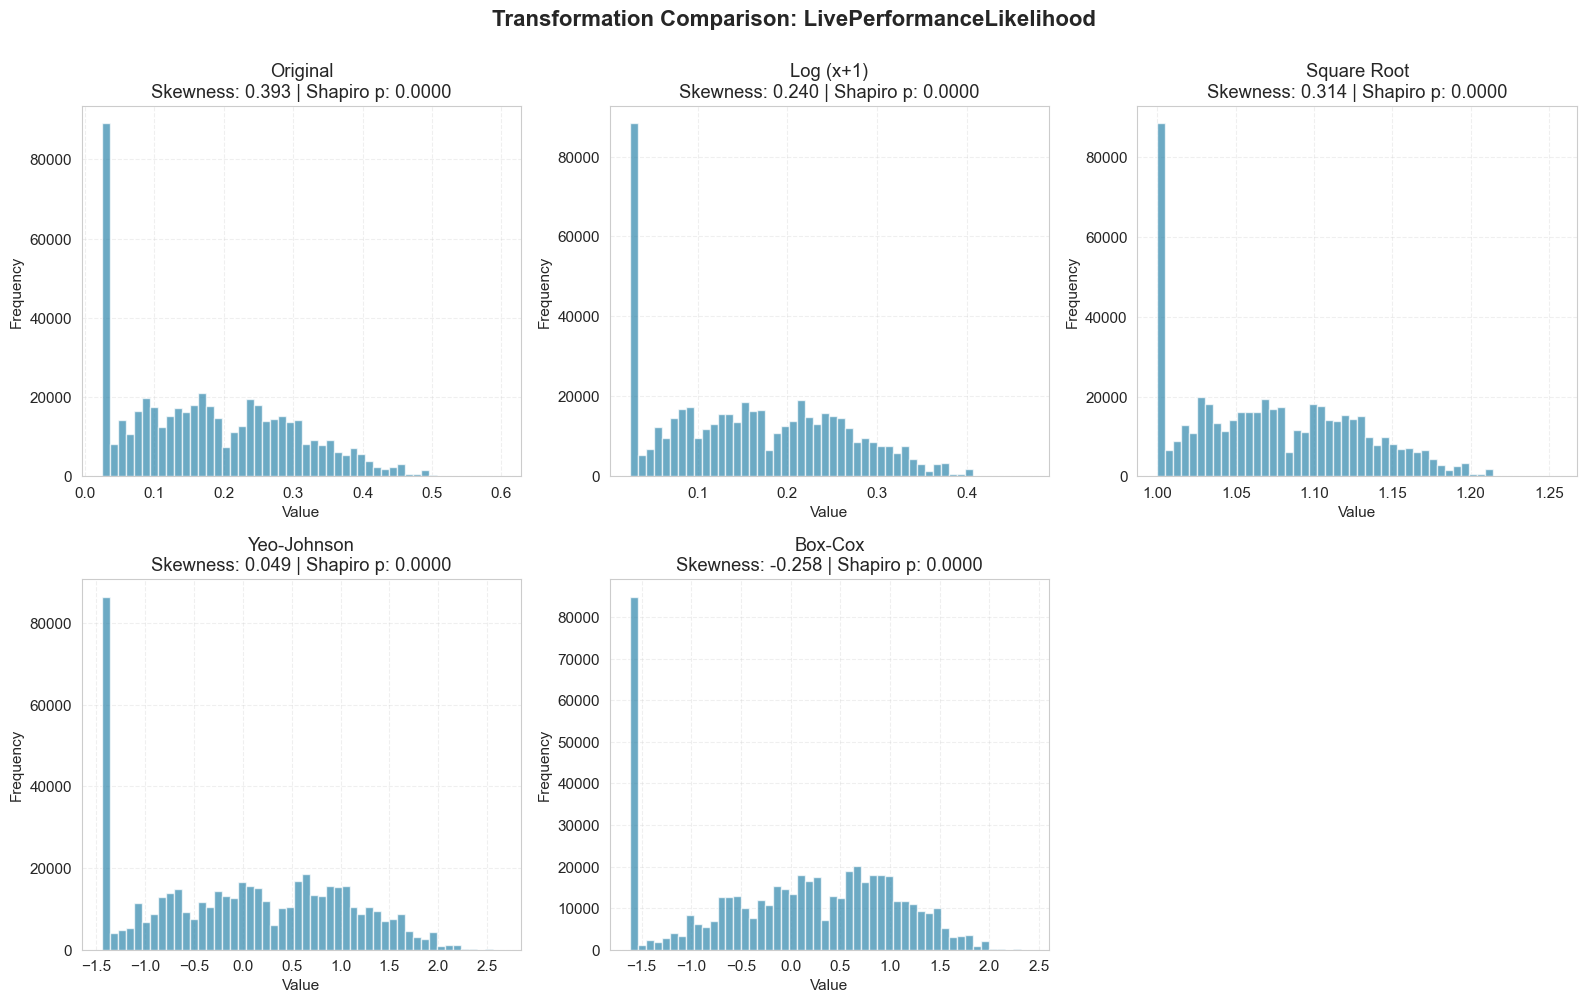


LivePerformanceLikelihood - Transformation Results (Ranked by Absolute Skewness):



,Transformation,Skewness,Abs_Skewness,Shapiro_p
3,Yeo-Johnson,0.049302,0.049302,2.074969e-39
1,Log (x+1),0.240137,0.240137,7.087278e-39
4,Box-Cox,-0.257747,0.257747,4.058998e-41
2,Square Root,0.313736,0.313736,3.618178e-39
0,Original,0.393321,0.393321,9.351393e-40


In [16]:
# Test transformation on moderately skewed feature
print("="*70)
print("MODERATELY SKEWED FEATURE ANALYSIS")
print("="*70)
transformation_results['LivePerformanceLikelihood'] = compare_transformations(
    df, 'LivePerformanceLikelihood'
)

Scaling Comparison on Normal-ish Feature:


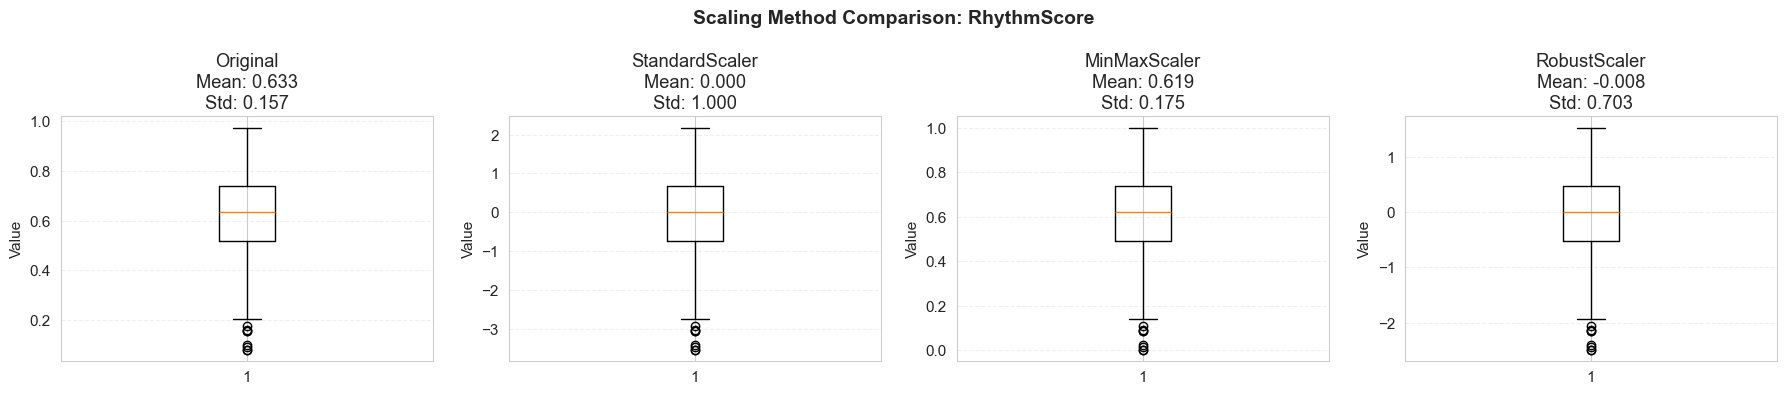


Scaling Comparison on Skewed Feature (before transformation):


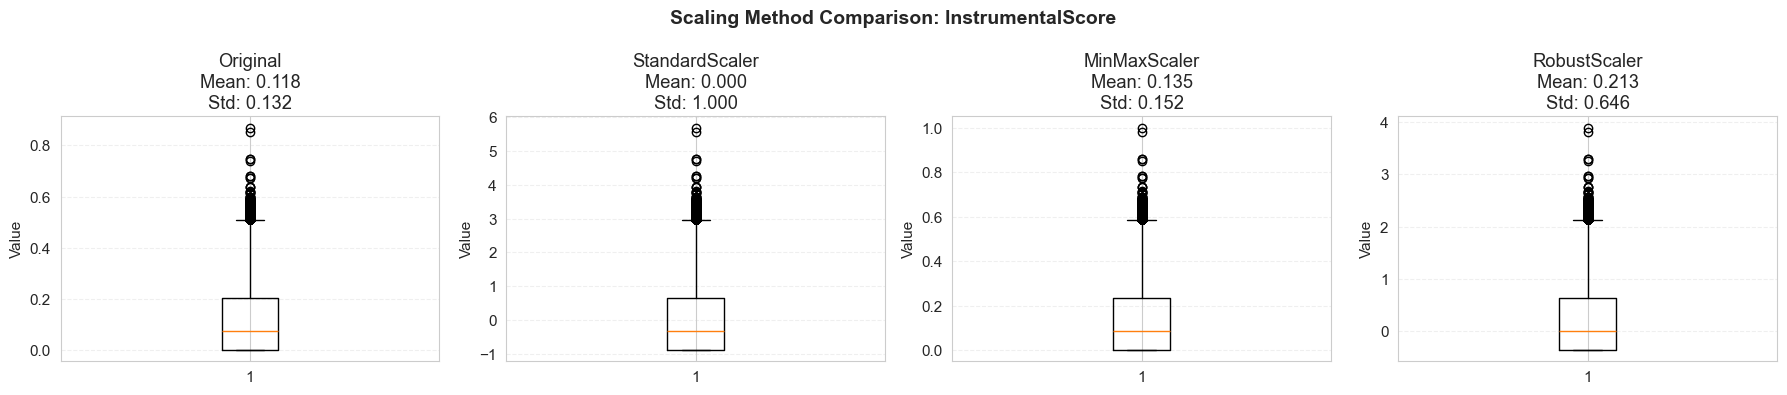

In [18]:
def compare_scaling_methods(data, feature_name):
    """
    Compare different scaling methods on a single feature.
    """
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    fig.suptitle(f'Scaling Method Comparison: {feature_name}', 
                 fontsize=14, fontweight='bold')
    
    feature = data[feature_name].values.reshape(-1, 1)
    
    scalers = {
        'Original': feature,
        'StandardScaler': StandardScaler().fit_transform(feature),
        'MinMaxScaler': MinMaxScaler().fit_transform(feature),
        'RobustScaler': RobustScaler().fit_transform(feature)
    }
    
    for idx, (name, scaled) in enumerate(scalers.items()):
        ax = axes[idx]
        ax.boxplot(scaled, vert=True)
        ax.set_title(f'{name}\nMean: {scaled.mean():.3f}\nStd: {scaled.std():.3f}')
        ax.set_ylabel('Value')
        ax.grid(alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    plt.show()

# Compare scaling on features with different characteristics
print("Scaling Comparison on Normal-ish Feature:")
compare_scaling_methods(df, 'RhythmScore')

print("\nScaling Comparison on Skewed Feature (before transformation):")
compare_scaling_methods(df, 'InstrumentalScore')

In [20]:
# Final decision on which features to transform
# Based on transformation exploration results
features_to_transform = feature_groups['highly_skewed'].copy()

# Decision: Include LivePerformanceLikelihood if transformation reduces skewness significantly
# Adjust based on your transformation results
# features_to_transform.append('LivePerformanceLikelihood')  # Uncomment if beneficial

features_normal = feature_groups['approximately_normal'].copy()
if 'LivePerformanceLikelihood' not in features_to_transform:
    features_normal.append('LivePerformanceLikelihood')

print("Final Feature Allocation:")
print(f"Features to transform: {features_to_transform}")
print(f"Features to scale only: {features_normal}")

Final Feature Allocation:
Features to transform: ['InstrumentalScore', 'VocalContent', 'AcousticQuality']
Features to scale only: ['RhythmScore', 'AudioLoudness', 'MoodScore', 'TrackDurationMs', 'Energy', 'LivePerformanceLikelihood']


### Selected Preprocessing Strategy Transformation
- Yeo-Johnson (Global)We selected Yeo-Johnson for all skewed features. While Box-Cox offered marginally better skew reduction for InstrumentalScore, Yeo-Johnson was prioritized for robustness—it handles zero and negative values natively without requiring manual offsets, ensuring a consistent and maintainable pipeline.
- Scaling: Model-Dependent
    - StandardScaler: Applied to Linear, GAM, and SVR models to center distributions ($z$-score), optimizing convergence for distance-based algorithms.
    - MinMaxScaler: Applied to Neural Networks to bound inputs to $[0, 1]$, preventing activation saturation.

    The logic defined above has been codified into the project's main executable script (preprocessing.py) via scikit-learn Pipelines. This ensures that all transformations are applied dynamically during training to prevent data leakage.